In [625]:
import numpy as np 
import pandas as pd
import os
import psycopg2
import geopandas as gpd

import importlib
from Secrets import secrets
# importlib.reload(secrets)

import matplotlib.pyplot as plt
import seaborn as sns

### Analysis

 - num of sales, avg price by areas 

 - AVG price per sq ft over time
 - num of transactions over time
 - - AVG price per sq ft by geography over time
 
 - the same type of property (sqft, rooms, old, freehold, detached etc) in difference areas > how much more pay based on the post code
 - the most variance in price within region, lsoa for the same type of property
 - cluster high price, low price areas
 - Do new builds really cost less than old properties and why?
 

# Avg price and num of transactions over time and by region

In [522]:
# Define Engine
engine = psycopg2.connect(database="postgres", user=secrets.user(), password=secrets.password(), host=secrets.host(), port='5432')
cur = engine.cursor()

# Get Data from AWS RDS PostgresSQL DB (all data within the database is publicly available and been scrapped and collected by myself)
cur.execute("""

SELECT 
    g.rg_name as region,  CAST (p.year AS INTEGER), 
    CAST(ROUND(AVG(p.price)::numeric,0 ) as integer) as avg_price, 
    count(*) as count, 
    count(distinct p.lsoa) as lsoa_count, 
    CAST(count(*)/count(distinct p.lsoa) AS INTEGER) as count_per_lsoa

from prices as p
join geo as g 
on g.lsoa = p.lsoa
group by g.rg_name, p.year;

""")
rows = cur.fetchall()
result = pd.DataFrame(rows, columns = [desc[0] for desc in cur.description])
result.head(2)

,region,year,avg_price,count,lsoa_count,count_per_lsoa
0,Barking and Dagenham,1995,50615,1488,110,13
1,Barking and Dagenham,1996,51670,1892,110,17


The above dataframe gives us average price, num of transactions per year and region in London, UK <br>
count_per_lsoa estimated the number of transactions per lsoa area. Because one region may have more property, therefore is likely to see more transactions, I use lsoa area ( lsoa area is defined as an area with aproximatly 1500 habitans) to normalize the data  <br>


CAGR (1995-2019) - 11.11%
Average property price droped by 29.04% between 2019 and 2020


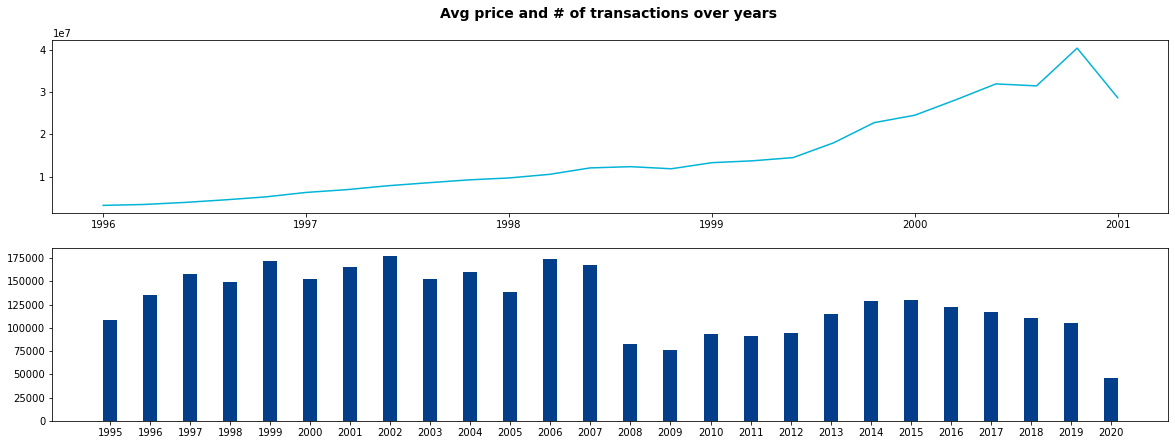

In [512]:
# Overall view of prices and num of transactions

cagr1995_2019 = pow(result_gp[result_gp.year == 2019]["avg_price"].iloc[0]/ result_gp[result_gp.year == 1995]["avg_price"].iloc[0], (1/(result_gp.shape[0]-2)) ) -1
print("CAGR (1995-2019) - {:.2f}%".format(cagr1995_2019*100) )

pricedrop2020 = -(np.float(result_gp[result_gp.year == 2020]["avg_price"].iloc[0]/result_gp[result_gp.year == 2019]["avg_price"].iloc[0])-1)
print("Average property price droped by {:.2f}% between 2019 and 2020".format(pricedrop2020*100) )

result_gp = result.groupby("year", as_index=False).sum()

fig, ax = plt.subplots(ncols =1, nrows = 2, figsize=(20, 7))

ax[0].set_title("Avg price and # of transactions over years \n", fontweight='bold', fontsize=14)
ax[0].plot(result_gp["avg_price"], color="#00b4d8")

width = 0.35
labels = result_gp["year"].values
x = np.arange(len(labels))
y = result_gp["count"].values
ax[1].bar(x, y, width, color="#023e8a")
ax[1].set_xticks(x)
ax[1].set_xticklabels(labels)
ax[0].set_xticklabels(labels)

plt.show()



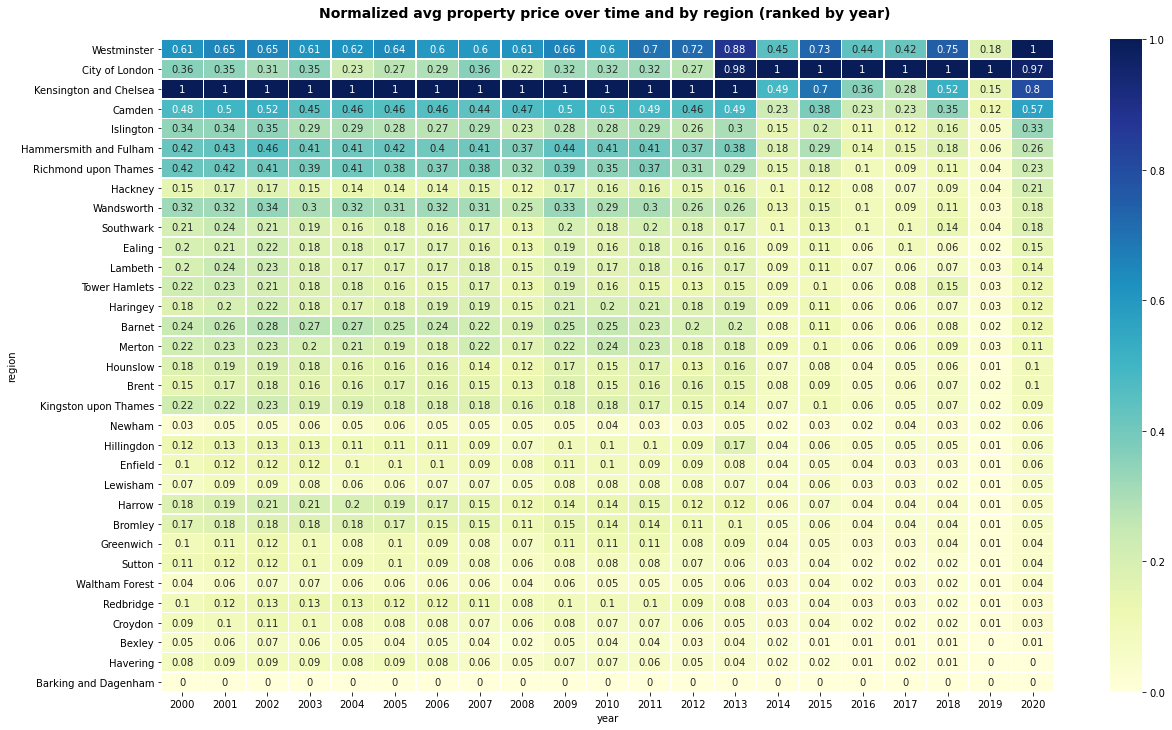

In [515]:
#### By Region view prices
####

# Reshape data into pivot table
result_pv = pd.pivot_table(result[result.year > 1999], index="region", columns="year", values="avg_price")
# Normalize data across each row, for each region ensure the avg price is represented as a number between 0 and 1
result_pv2 = result_pv.subtract(result_pv.min(axis=0), axis=1).div(result_pv.max(axis=0) -result_pv.min(axis=0), axis=1).round(2).sort_values(by=2020, ascending=False)

# Plot 
fig, ax = plt.subplots(figsize=(20, 12))
sns.heatmap(result_pv2, annot=True, linewidths=.5, ax=ax, cmap="YlGnBu")
ax.set_title("Normalized avg property price over time and by region (ranked by year) \n", fontweight='bold', fontsize=14)
plt.show()

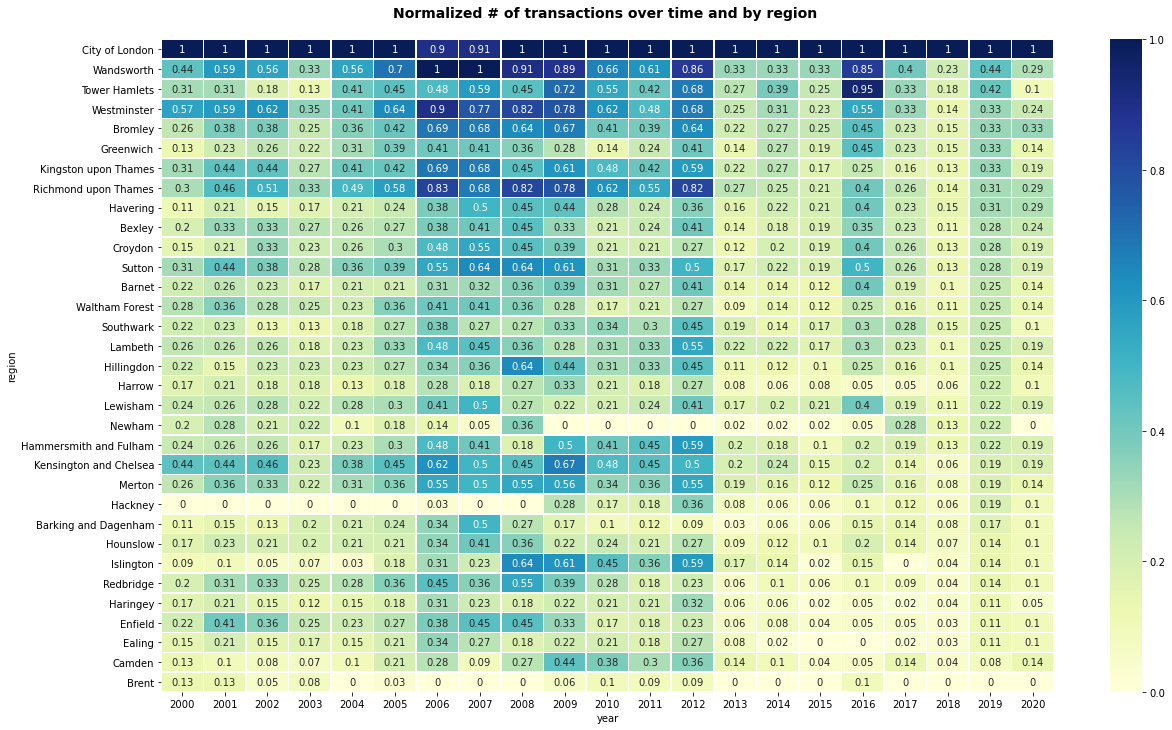

In [523]:
#### By Region view # of transactions
####

# Reshape data into pivot table
result_pv = pd.pivot_table(result[result.year > 1999], index="region", columns="year", values="count_per_lsoa")
# Normalize data across each row, for each region ensure the avg price is represented as a number between 0 and 1
result_pv2 = result_pv.subtract(result_pv.min(axis=0), axis=1).div(result_pv.max(axis=0) -result_pv.min(axis=0), axis=1).round(2).sort_values(by=2019, ascending=False)

# Plot 
fig, ax = plt.subplots(figsize=(20, 12))
sns.heatmap(result_pv2, annot=True, linewidths=.5, ax=ax, cmap="YlGnBu")
ax.set_title("Normalized # of transactions over time and by region \n", fontweight='bold', fontsize=14)
plt.show()

### Comments


- During 2008 and 2009 crises, the number of sold property was half of what it was during 2007 (75k versus 150k)
- On avergae the prices rise by 11% each year
- The average property prices have not dropped during the crises and continued to rise significatly after 2009
- COVID has impacted property transactions (at all time lowest 50k) and property prices which dipped by around 30%
- Up until 2013 the most expensive property sold was in Chelse and Kensington, after 2013 in City of London
- City of London sees the least of transactions (if not accounted for lsoa areas/population) and has the most transactions when adjusting for population
- Tower Hamlets and Wandsworth sees inflow of transactions during specific years (probably due to new developments)
- In fact when removing any new development sales (below) the Tower Hamlets does not have large num of transactions in 2016 and 2009


In [532]:
cur.execute("""
SELECT 
    g.rg_name as region,  CAST (p.year AS INTEGER), 
    CAST(ROUND(AVG(p.price)::numeric,0 ) as integer) as avg_price, 
    count(*) as count, 
    count(distinct p.lsoa) as lsoa_count, 
    CAST(count(*)/count(distinct p.lsoa) AS INTEGER) as count_per_lsoa
from prices as p
join geo as g 
on g.lsoa = p.lsoa
where p.new = 'N'
group by g.rg_name, p.year;
""")
rows = cur.fetchall()
result = pd.DataFrame(rows, columns = [desc[0] for desc in cur.description])
result.head(2)

,region,year,avg_price,count,lsoa_count,count_per_lsoa
0,Barking and Dagenham,1995,51119,1332,110,12
1,Barking and Dagenham,1996,51170,1699,110,15


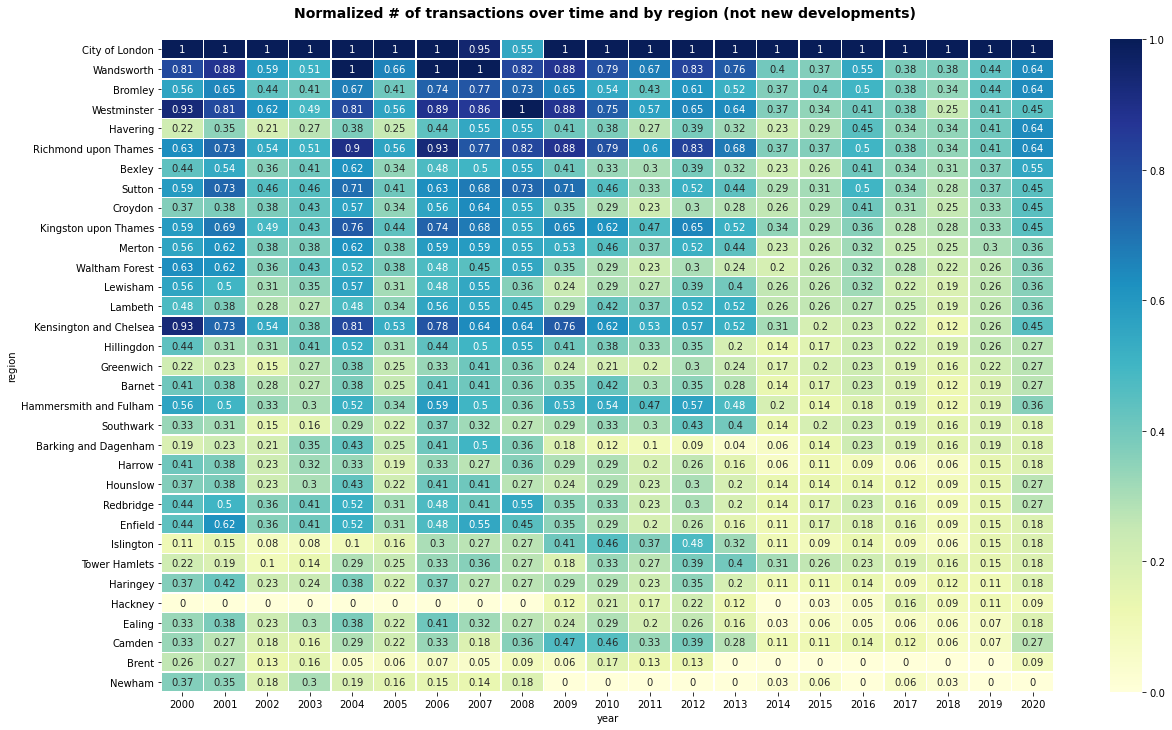

In [533]:
#### By Region view prices (Not new developments)
####

# Reshape data into pivot table
result_pv = pd.pivot_table(result[result.year > 1999], index="region", columns="year", values="count_per_lsoa")
# Normalize data across each row, for each region ensure the avg price is represented as a number between 0 and 1
result_pv2 = result_pv.subtract(result_pv.min(axis=0), axis=1).div(result_pv.max(axis=0) -result_pv.min(axis=0), axis=1).round(2).sort_values(by=2019, ascending=False)

# Plot 
fig, ax = plt.subplots(figsize=(20, 12))
sns.heatmap(result_pv2, annot=True, linewidths=.5, ax=ax, cmap="YlGnBu")
ax.set_title("Normalized # of transactions over time and by region (not new developments) \n", fontweight='bold', fontsize=14)
plt.show()

# Avg price per sq ft & rooms

In [626]:
# Get Data from AWS RDS PostgresSQL DB (all data within the database is publicly available and been scrapped and collected by myself)

engine = psycopg2.connect(database="postgres", user=secrets.user(), password=secrets.password(), host=secrets.host(), port='5432')
cur = engine.cursor()

cur.execute("""

SELECT 
    p.brn,
    CAST(ROUND((e.total_floor_area)::numeric,0 ) as integer) as sqm,
    CAST(ROUND((p.price/e.total_floor_area)::numeric, 3 ) as integer) as sqm_price,
    e.number_habitable_rooms

from prices as p
join epc as e
on e.brn = p.brn

where e.total_floor_area <> 0 and e.number_habitable_rooms <> 0 and e.number_habitable_rooms is not null 
and e.total_floor_area is not null
and e.brn is not null;

""")
rows = cur.fetchall()
result = pd.DataFrame(rows, columns = [desc[0] for desc in cur.description])
result.head(2)

,brn,sqm,sqm_price,number_habitable_rooms
0,6.498447e+09,48,1250,3.0
1,8.608298e+09,102,755,5.0


In [627]:
result.describe().round()
# There are appareant outliers with extremly high sqft and price per sq ft which we will need to adjust to be able to analyse the distribution

,brn,sqm,sqm_price,number_habitable_rooms
count,3.055723e+06,3055723.0,3055723.0,3055723.0
mean,4.652883e+09,82.0,3974.0,4.0
std,2.899369e+09,68.0,5764.0,2.0
min,2.600000e+01,1.0,0.0,1.0
25%,2.092934e+09,55.0,1981.0,3.0
50%,4.483819e+09,73.0,3204.0,3.0
75%,7.123233e+09,96.0,4900.0,5.0
max,9.999999e+09,53041.0,2095588.0,99.0


/home/elena/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


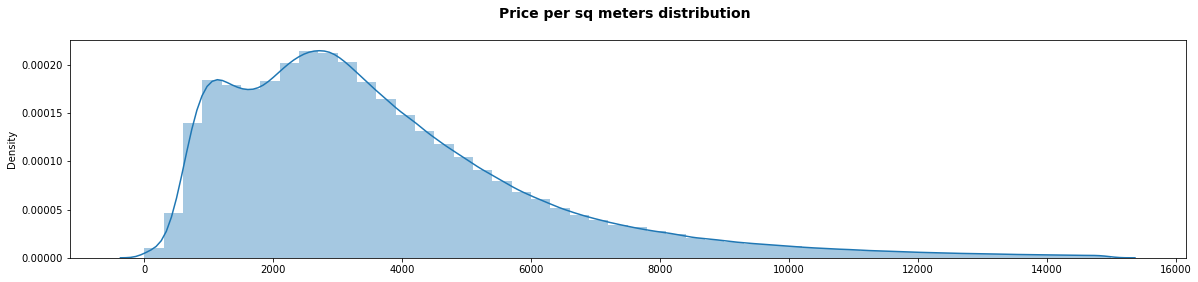

In [629]:
# set to ~ 2sd from mean
outlier_cutoff = 15000
values_sqft_price = result[result["sqm_price"] < outlier_cutoff].sqm_price.values
fig, ax = plt.subplots(figsize=(20, 4))
sns.distplot(values_sqft_price, ax=ax)
ax.set_title("Price per sq meters distribution \n", fontweight='bold', fontsize=14)
plt.show()

# There are two humps indicating potential two clusters with different distribution of property prices
# TODO: investigate two clusters when segment properties and regions

/home/elena/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


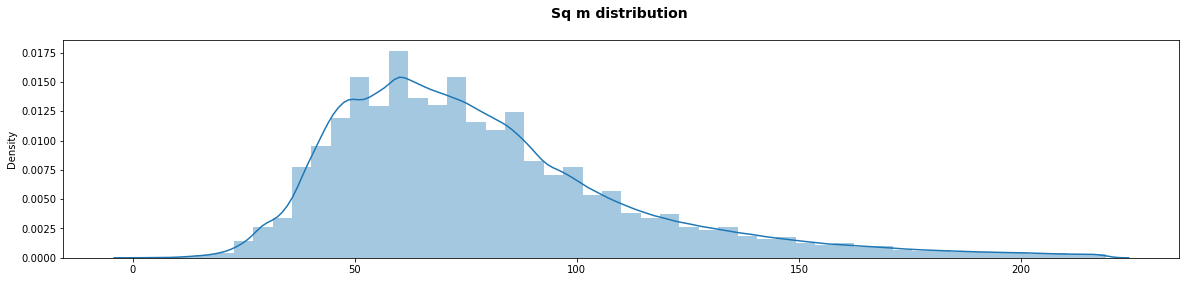

In [630]:
# set to ~ 2sd from mean
outlier_cutoff = 220
values_sqft = result[result["sqm"] < outlier_cutoff].sqm.values
fig, ax = plt.subplots(figsize=(20, 4))
sns.distplot(values_sqft, ax=ax)
ax.set_title("Sq m distribution \n", fontweight='bold', fontsize=14)
plt.show()

# Sq ft is somewhat normally distributed with longer right tail indicating rare properties with much higher sq ft
# Average sq ft is around 60 and as per below analysis this is equal to around 3 room property

/home/elena/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


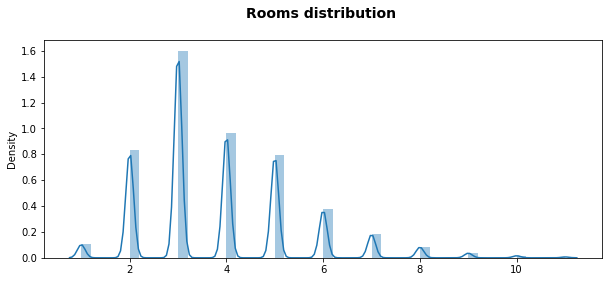

In [562]:
# set to ~ 2sd from mean
outlier_cutoff = 12
values_rooms = result[result["number_habitable_rooms"] < outlier_cutoff].number_habitable_rooms.values
fig, ax = plt.subplots(figsize=(10, 4))
sns.distplot(values_rooms, ax=ax)
ax.set_title("Rooms distribution \n", fontweight='bold', fontsize=14)
plt.show()

In [662]:
engine = psycopg2.connect(database="postgres", user=secrets.user(), password=secrets.password(), host=secrets.host(), port='5432')

sql = """
select
    lsoa, lsoa_name, rg_name, geometry, avg(count) as mean_yearly
    
from
    (SELECT 
        g.lsoa, g.lsoa_name, g.rg_name, g.geometry, count(p.brn) as count
    from prices as p
    join geo as g
    on p.lsoa = g.lsoa
    where p.new = 'Y' and p.brn is not null 
    group by g.lsoa, g.lsoa_name, g.rg_name, g.geometry, p.year) as t
    
group by lsoa, lsoa_name, rg_name, geometry;
"""

gdf_new = gpd.read_postgis(sql, engine, geom_col='geometry') 
gdf_new.head(2)

,lsoa,lsoa_name,rg_name,geometry,mean_yearly
0,E01000005,City of London 001E,City of London,"POLYGON ((533807.946 180767.770, 533649.063 18...",40.0
1,E01000006,Barking and Dagenham 016A,Barking and Dagenham,"POLYGON ((545122.049 184314.931, 545271.917 18...",52.0


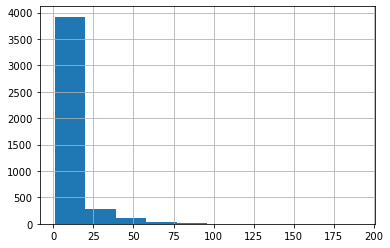

In [663]:
gdf_new["mean_yearly"].hist()

Top 5 regions with most num of new developments sold
          rg_name  mean_yearly
29  Tower Hamlets  3005.103339
27      Southwark  1807.491668
10      Greenwich  1774.265634
24         Newham  1736.288319
1          Barnet  1721.860379
 

 Top 10 lsoa areas
           lsoa           lsoa_name  mean_yearly
3989  E01004562     Wandsworth 002B   190.857143
4298  E01033583         Newham 013G   157.000000
4292  E01033577         Newham 037E   149.250000
4218  E01032773  Tower Hamlets 032D   125.166667
4223  E01032778  Tower Hamlets 028G   117.538462
1410  E01001667      Greenwich 036B   113.857143
4291  E01033576         Newham 034H   108.800000
4260  E01033207        Lambeth 004F   108.666667
4252  E01033132     Wandsworth 002H    98.555556
4289  E01033574         Newham 034F    96.250000


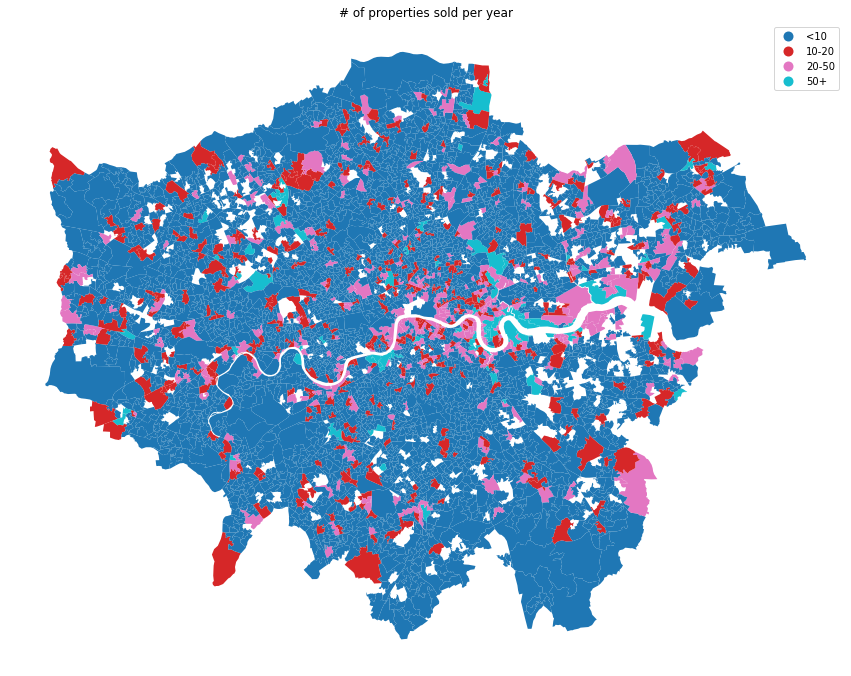

In [666]:
print("Top 5 regions with most num of new developments sold")
print(gdf_new.groupby("rg_name", as_index=False)["mean_yearly"].sum().sort_values(by="mean_yearly", ascending=False)[:5])

print(" ")
print("\n Top 10 lsoa areas")
print(gdf_new.sort_values(by="mean_yearly", ascending=False)[:10][["lsoa", "lsoa_name", "mean_yearly"]])

# Group count for better visualization
gdf_new["count_bins"] = pd.cut(gdf_new["mean_yearly"], [0, 10, 20, 50, 500],labels=["<10", "10-20", "20-50", "50+"])
    

fig, ax = plt.subplots(figsize=(15, 15))
ax.axis('off')
gdf_new.plot(ax = ax, column="count_bins",legend=True)
ax.set_title("# of properties sold per year")
plt.show()

In [349]:
#### Understand the price per sq ft variance across various regions
## London has a few regions with the property prices much higher than the city's average
## which makes it hard to visualize or analyse the prices
## Therefore, separate the data into 2 chunks:
# Those areas with prices being below 1 ST DEV from mean
# Those areas with prices significantly above 1 ST DEV from mean


engine = psycopg2.connect(database="postgres", user=secrets.user(), password=secrets.password(), host=secrets.host(), port='5432')
cur = engine.cursor()
cur.execute("""
SELECT 
    g.rg_name,
    CAST(ROUND(AVG(p.price)::numeric,0 ) as integer) as avg_price,
    CAST(ROUND(AVG(e.total_floor_area)::numeric,0 ) as integer) as avg_sqft,
    CAST(ROUND(AVG(e.number_habitable_rooms)::numeric,0 ) as integer) as avg_rooms,
    CAST(ROUND( AVG(p.price/e.total_floor_area)::numeric, 3 ) as integer) as sqft_price,
    CAST(ROUND( AVG(p.price/e.number_habitable_rooms)::numeric, 3 ) as integer) as price_per_room

from prices as p
join epc as e
on e.brn = p.brn
join geo as g
on p.lsoa = g.lsoa
where e.total_floor_area <> 0 and e.number_habitable_rooms <> 0 and e.number_habitable_rooms is not null and e.total_floor_area is not null
and p.year = 2019
group by g.rg_name;

""")
rows = cur.fetchall()
result = pd.DataFrame(rows, columns = [desc[0] for desc in cur.description])

result["sqft_price_stdev"] = abs(np.round( (result["sqft_price"]-result["sqft_price"].mean()) / result["sqft_price"].std(), 1))
result = result.sort_values(by="sqft_price_stdev", ascending=False)

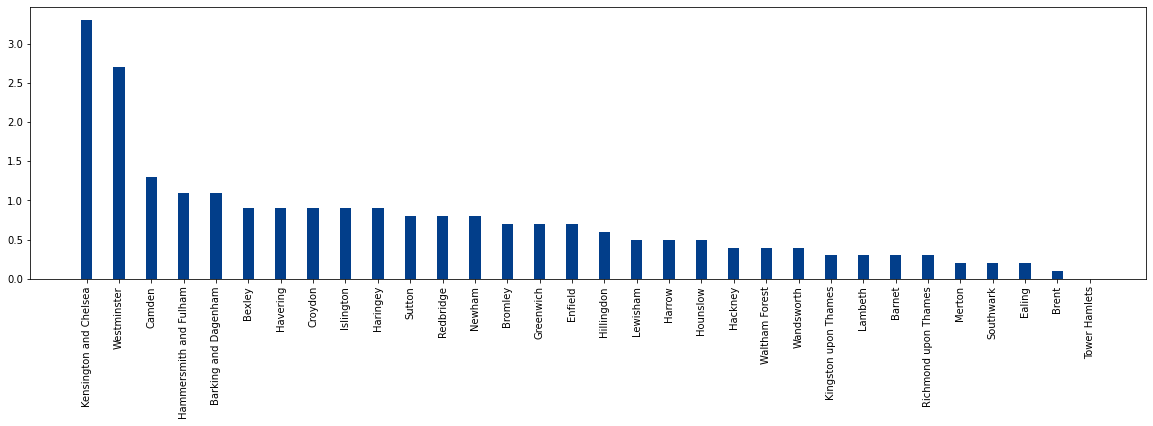

In [350]:
fig, ax = plt.subplots(figsize=(20, 5))

width = 0.35
labels = result["rg_name"].values
x = np.arange(len(labels))
y = result["sqft_price_stdev"].values
ax.bar(x, y, width, color="#023e8a")
ax.set_xticks(x)
ax.tick_params(axis='x', rotation=90)
ax.set_xticklabels(labels)
ax.set_xticklabels(labels)

plt.show()

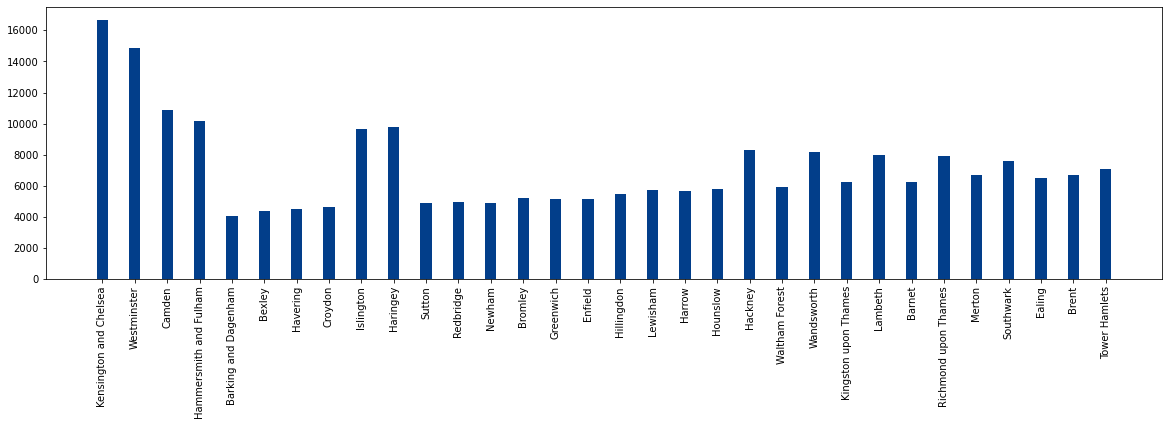

In [371]:
fig, ax = plt.subplots(figsize=(20, 5))

width = 0.35
labels = result["rg_name"].values
x = np.arange(len(labels))
y = result["sqft_price"].values
ax.bar(x, y, width, color="#023e8a")
ax.set_xticks(x)
ax.tick_params(axis='x', rotation=90)
ax.set_xticklabels(labels)
ax.set_xticklabels(labels)

plt.show()

In [351]:
list_of_regions_1stdev = result[result.sqft_price_stdev <1.01]["rg_name"].values
list_of_regions_more1stdev = result[result.sqft_price_stdev > 0.99]["rg_name"].values

In [668]:
engine = psycopg2.connect(database="postgres", user=secrets.user(), password=secrets.password(), host=secrets.host(), port='5432')

sql = """
SELECT 
    g.rg_name, g.lsoa, g.lsoa_name, g.geometry,
    CAST(ROUND(AVG(p.price)::numeric,0 ) as integer) as avg_price,
    CAST(ROUND(AVG(e.total_floor_area)::numeric,0 ) as integer) as avg_sqft,
    CAST(ROUND(AVG(e.number_habitable_rooms)::numeric,0 ) as integer) as avg_rooms,
    CAST(ROUND( AVG(p.price/e.total_floor_area)::numeric, 3 ) as integer) as sqft_price,
    CAST(ROUND( AVG(p.price/e.number_habitable_rooms)::numeric, 3 ) as integer) as price_per_room

from prices as p
join epc as e
on e.brn = p.brn
join geo as g
on p.lsoa = g.lsoa
where e.total_floor_area <> 0 and e.number_habitable_rooms <> 0 and e.number_habitable_rooms is not null and e.total_floor_area is not null
and p.year = 2019

group by g.rg_name, g.lsoa, g.lsoa_name, g.geometry


"""

gdf_all = gpd.read_postgis(sql, engine, geom_col='geometry') 
gdf_all.head(2)

,rg_name,lsoa,lsoa_name,geometry,avg_price,avg_sqft,avg_rooms,sqft_price,price_per_room
0,Barking and Dagenham,E01000006,Barking and Dagenham 016A,"POLYGON ((545122.049 184314.931, 545271.917 18...",272229,63,4,4432,74181
1,Barking and Dagenham,E01000007,Barking and Dagenham 015A,"POLYGON ((544180.347 184700.582, 544317.196 18...",227000,53,3,4178,85424


Top regions by the highest price per sq ft 

                   rg_name  sqft_price_norm
31             Westminster             37.9
12                Haringey             34.1
20                 Lambeth             12.9
17               Islington             11.6
11  Hammersmith and Fulham              8.1
18  Kensington and Chelsea              7.0
10                 Hackney              4.2
13                  Harrow              2.8
3                    Brent              2.8
5                   Camden              2.7
15              Hillingdon              2.6
26               Southwark              2.3
7                   Ealing              1.8
25    Richmond upon Thames              1.6
30              Wandsworth              1.6
28           Tower Hamlets              1.4
29          Waltham Forest              1.3
1                   Barnet              1.2
23                  Newham              1.0
22                  Merton              1.0
16                Hounslow     

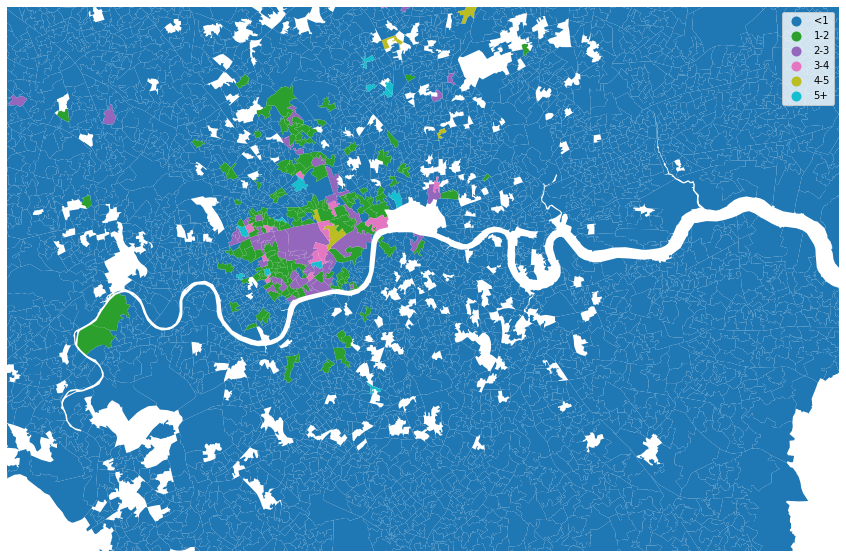

In [670]:
# Group count for better visualization
gdf_new["count_bins"] = pd.cut(gdf_new["mean_yearly"], [0, 10, 20, 50, 500],labels=["<10", "10-20", "20-50", "50+"])

### Areas within > 1 st dev of the mean price from entire london
##
# Calcs
# Recalculate mean, st dev
gdf_all["sqft_price_norm"] = abs(np.round( (gdf_all["sqft_price"]-gdf_all["sqft_price"].mean()) / gdf_all["sqft_price"].std(), 1))

print("Top regions by the highest price per sq ft \n")
print(gdf_all.groupby("rg_name", as_index=False)["sqft_price_norm"].max().sort_values(by="sqft_price_norm", ascending=False))

# Group count for better visualization
gdf_all["sqft_price_norm_bins"] = pd.cut(gdf_all["sqft_price_norm"], [0, 1, 2, 3, 4, 5, 100], labels=["<1", "1-2", "2-3", "3-4", "4-5", "5+"])


fig, ax = plt.subplots(figsize=(20, 10))
ax.axis('off')
gdf_all.plot(ax = ax, column="sqft_price_norm_bins", legend=True)
adj_x = 10000
adj_y = 10000
minx, miny, maxx, maxy = gdf_all.total_bounds
ax.set_xlim(minx + adj_x, maxx - adj_x)
ax.set_ylim(miny  + adj_y, maxy - adj_y)
plt.show()

Top regions by the highest price per sq ft 

                  rg_name  sqft_price_norm
4             Westminster              1.5
3  Kensington and Chelsea              1.3
1                  Camden              1.0
0    Barking and Dagenham              0.9
2  Hammersmith and Fulham              0.7


/home/elena/anaconda3/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


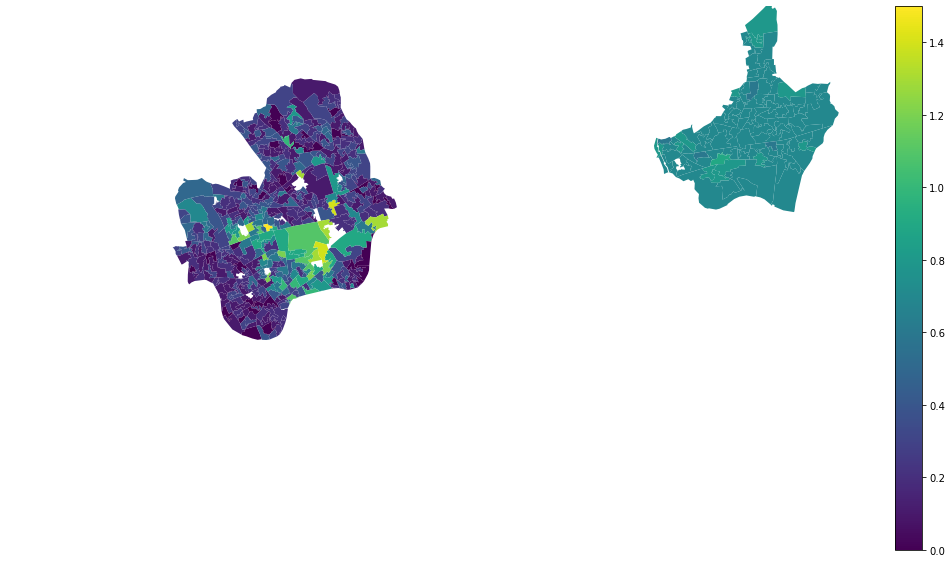

In [376]:
#### Areas within > 1 st dev of the mean price from entire london
##
# Calcs
gdf_all_more1stdev = gdf_all[gdf_all.rg_name.isin(list_of_regions_more1stdev)]
# Recalculate mean, st dev
gdf_all_more1stdev["sqft_price_norm"] = abs(np.round( (gdf_all_more1stdev["sqft_price"]-gdf_all_more1stdev["sqft_price"].mean()) / gdf_all_more1stdev["sqft_price"].std(), 1))
# Remove outliers (> 2 st dev)
gdf_all_more1stdev = gdf_all_more1stdev[gdf_all_more1stdev["sqft_price_norm"] <2]

print("Top regions by the highest price per sq ft \n")
print(gdf_all_more1stdev.groupby("rg_name", as_index=False)["sqft_price_norm"].max().sort_values(by="sqft_price_norm", ascending=False))

fig, ax = plt.subplots(figsize=(20, 10))
ax.axis('off')
gdf_all_more1stdev.plot(ax = ax, column="sqft_price_norm", legend=True)
adj_x = 10000
adj_y = 10000
minx, miny, maxx, maxy = gdf_all.total_bounds
ax.set_xlim(minx + adj_x, maxx - adj_x)
ax.set_ylim(miny  + adj_y, maxy - adj_y)
plt.show()

/home/elena/anaconda3/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


Top regions by the highest price per sq ft 

          rg_name  sqft_price_norm
14      Islington              1.9
2           Brent              1.9
24  Tower Hamlets              1.9
0          Barnet              1.8
8         Hackney              1.7


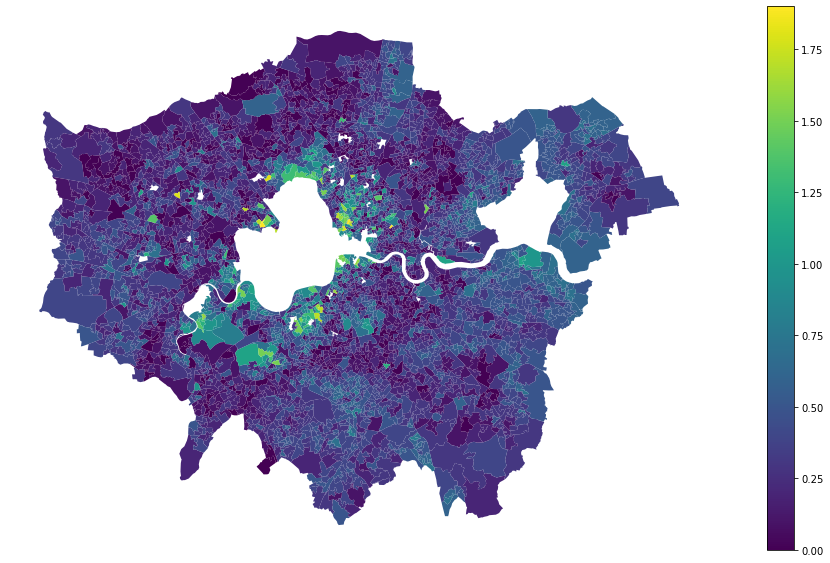

In [377]:
#### Areas within 1 st dev of the mean price from entire london
##
# Calcs
gdf_all_1stdev = gdf_all[gdf_all.rg_name.isin(list_of_regions_1stdev)]
# Recalculate mean, st dev
gdf_all_1stdev["sqft_price_norm"] = abs(np.round( (gdf_all_1stdev["sqft_price"]-gdf_all_1stdev["sqft_price"].mean()) / gdf_all_1stdev["sqft_price"].std(), 1))
# Remove outliers (> 2 st dev)
gdf_all_1stdev = gdf_all_1stdev[gdf_all_1stdev["sqft_price_norm"] <2]

print("Top regions by the highest price per sq ft \n")
print(gdf_all_1stdev.groupby("rg_name", as_index=False)["sqft_price_norm"].max().sort_values(by="sqft_price_norm", ascending=False)[:5])


fig, ax = plt.subplots(figsize=(20, 10))
ax.axis('off')
gdf_all_1stdev.plot(ax = ax, column="sqft_price_norm", legend=True)

plt.show()

In [601]:
result.rg_name.unique()

array(['Barking and Dagenham', 'Barnet', 'Bexley', 'Brent', 'Bromley',
       'Camden', 'Croydon', 'Ealing', 'Enfield', 'Greenwich', 'Hackney',
       'Hammersmith and Fulham', 'Haringey', 'Harrow', 'Havering',
       'Hillingdon', 'Hounslow', 'Islington', 'Kensington and Chelsea',
       'Kingston upon Thames', 'Lambeth', 'Lewisham', 'Merton', 'Newham',
       'Redbridge', 'Richmond upon Thames', 'Southwark', 'Sutton',
       'Tower Hamlets', 'Waltham Forest', 'Wandsworth', 'Westminster',
       'City of London'], dtype=object)

In [585]:
result.head()

,year,new,duration,type,rg_name,avg_price,avg_sqft,avg_rooms,sqft_price,price_per_room
0,1995,N,F,D,Barking and Dagenham,57045,104,6,569,11435
1,1995,N,F,D,Barnet,255030,204,7,1319,34747
2,1995,N,F,D,Bexley,109778,110,5,1063,21771
3,1995,N,F,D,Brent,153343,163,7,1054,27125
4,1995,N,F,D,Bromley,169613,156,6,1177,26857


In [564]:
engine = psycopg2.connect(database="postgres", user=secrets.user(), password=secrets.password(), host=secrets.host(), port='5432')
cur = engine.cursor()
cur.execute("""
SELECT 
    CAST (p.year AS INTEGER), p.new, p.duration, p.type, g.rg_name,
    CAST(ROUND(AVG(p.price)::numeric,0 ) as integer) as avg_price,
    CAST(ROUND(AVG(e.total_floor_area)::numeric,0 ) as integer) as avg_sqft,
    CAST(ROUND(AVG(e.number_habitable_rooms)::numeric,0 ) as integer) as avg_rooms,
    CAST(ROUND(AVG(p.price/e.total_floor_area)::numeric, 3 ) as integer) as sqft_price,
    CAST(ROUND(AVG(p.price/e.number_habitable_rooms)::numeric, 3 ) as integer) as price_per_room

from prices as p
join epc as e
on e.brn = p.brn
join geo as g
on p.lsoa = g.lsoa
where e.total_floor_area <> 0 and e.number_habitable_rooms <> 0 and e.number_habitable_rooms is not null and e.total_floor_area is not null

group by p.year, p.new, p.duration, p.type, g.rg_name
having CAST(ROUND(AVG(p.price/e.total_floor_area)::numeric, 3 ) as integer) < 25000;

""")
rows = cur.fetchall()
result = pd.DataFrame(rows, columns = [desc[0] for desc in cur.description])


In [579]:
rooms_summary = result[result.year > 2015].groupby("avg_rooms", as_index=False).agg({"avg_sqft":"mean", "avg_price":"mean", "sqft_price": "mean"}).round()
rooms_summary = rooms_summary[rooms_summary.avg_rooms<10]
rooms_summary.head(2)

,avg_rooms,avg_sqft,avg_price,sqft_price
0,1,33.0,303178.0,9285.0
1,2,50.0,442082.0,8734.0


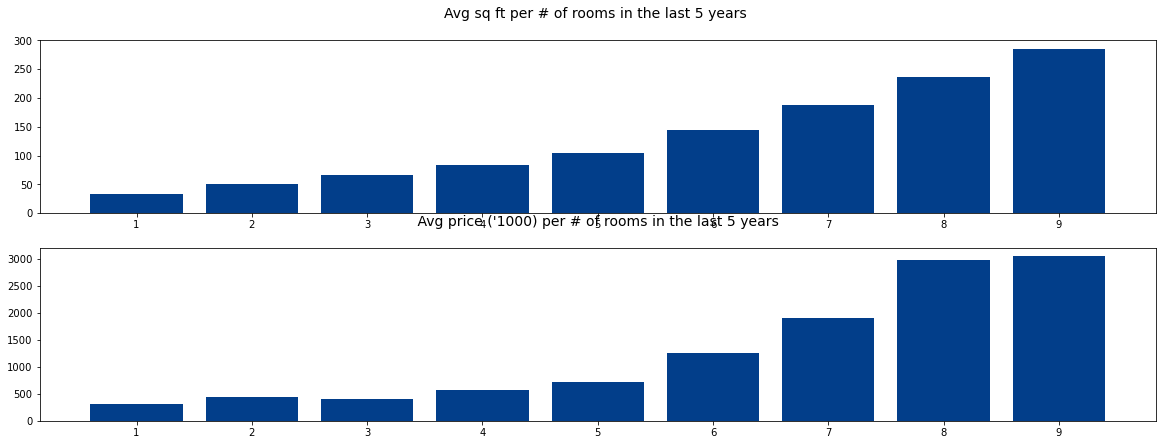

In [581]:
fig, ax = plt.subplots(ncols =1, nrows = 2, figsize=(20, 7))

labels = rooms_summary["avg_rooms"].values
x = np.arange(len(labels))

ax[0].set_title("Avg sq ft per # of rooms in the last 5 years \n", fontsize=14)
y = rooms_summary["avg_sqft"].values
ax[0].bar(x, y, color="#023e8a")
ax[0].set_xticks(x)
ax[0].set_xticklabels(labels)


ax[1].set_title("\n Avg price ('1000) per # of rooms in the last 5 years \n", fontsize=14)
y = rooms_summary["avg_price"].values/1000
ax[1].bar(x, y, color="#023e8a")

ax[1].set_xticks(x)
ax[1].set_xticklabels(labels)

plt.show()

# The avg price for 2, 3 property is not much different and is around 500k in the last 5 years

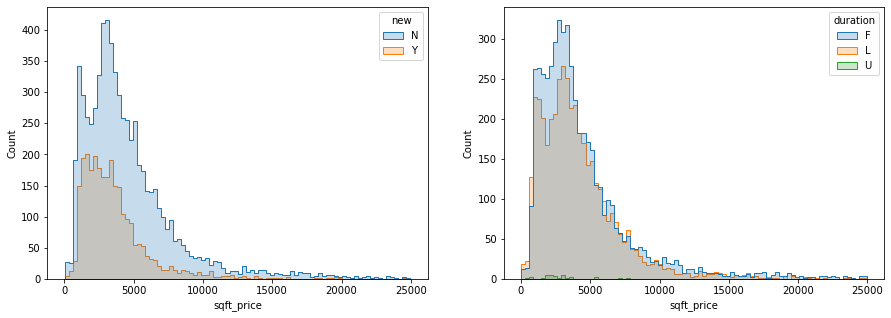

In [566]:
# all
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

sns.histplot(result, x="sqft_price", hue="new", element="step", ax=ax[0])
sns.histplot(result, x="sqft_price", hue="duration", element="step", ax=ax[1])

plt.show()

# The below suggests the price per sq ft is higher for old properties than new, and freehold than leasehold
# Freehold provides the owner the unlimited rights to the property (leashold has an expiration date) therefore it is expected
# that leasehold is less expensive
# However, I would expect the new property to be more expensive than older, requires more understanding and investigation
# Potentially most new property are smaller, in less expensive areas (not City) therefore prices shows lower

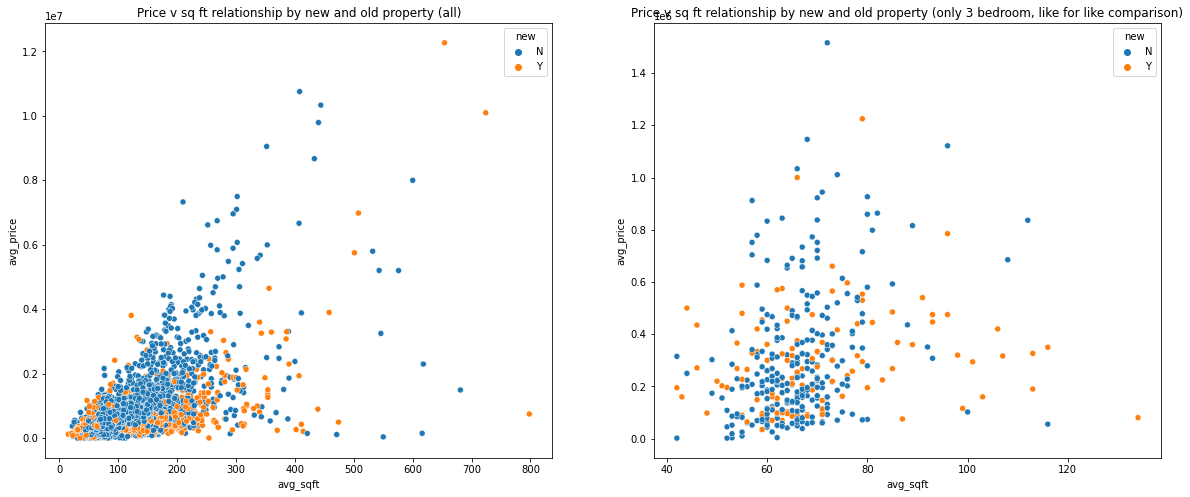

In [597]:
# Relationship between price and sq ft
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(20, 8))

temp = result[ (result.duration == "F") & (result.avg_rooms == 3)]
sns.scatterplot(data=result, x="avg_sqft", y="avg_price", hue="new", ax=ax[0])
ax[0].set_title("Price v sq ft relationship by new and old property (all)")

sns.scatterplot(data=temp, x="avg_sqft", y="avg_price", hue="new", ax=ax[1])
ax[1].set_title("Price v sq ft relationship by new and old property (only 3 bedroom, like for like comparison)")

plt.show()

# It is possible that most new builds are smaller and have less bedrooms therefore usually have lower price than older properties

In [600]:
result[result.year>2010].groupby(["new", "duration"], as_index=False).agg({"avg_rooms":"mean", "avg_sqft": "mean", "avg_price":"mean"})

,new,duration,avg_rooms,avg_sqft,avg_price
0,N,F,5.037187,115.772143,885821.520622
1,N,L,3.548339,78.067897,494794.683395
2,Y,F,4.868794,111.117021,580380.620567
3,Y,L,3.076159,74.748344,488104.956954


In [608]:
result[result.rg_name=="Westminster"].groupby(["new", "duration"], as_index=False).agg({"avg_rooms":"mean", "avg_sqft": "mean", "avg_price":"mean", "year":"count"}).round()
# Westminster was identified as one of the most expensive areas in London
# the new property price is still higher in this area than old property, whereas the sq ft is only slightly smaller

,new,duration,avg_rooms,avg_sqft,avg_price,year
0,N,F,6.0,188.0,2165390.0,103
1,N,L,5.0,140.0,1153053.0,95
2,N,U,3.0,101.0,380000.0,1
3,Y,F,6.0,166.0,655598.0,31
4,Y,L,4.0,141.0,746235.0,45


In [605]:
result[result.rg_name=="Tower Hamlets"].groupby(["new", "duration"], as_index=False).agg({"avg_rooms":"mean", "avg_sqft": "mean", "avg_price":"mean", "year":"count"}).round()
# Tower Hamlets was identified as one area with many new developments and more affordable pricing
# the new property price is still higher in this area than old property, whereas the sq ft is only slightly smaller

,new,duration,avg_rooms,avg_sqft,avg_price,year
0,N,F,5.0,100.0,466560.0,107
1,N,L,3.0,76.0,308896.0,92
2,Y,F,5.0,96.0,262878.0,48
3,Y,L,3.0,77.0,288930.0,42


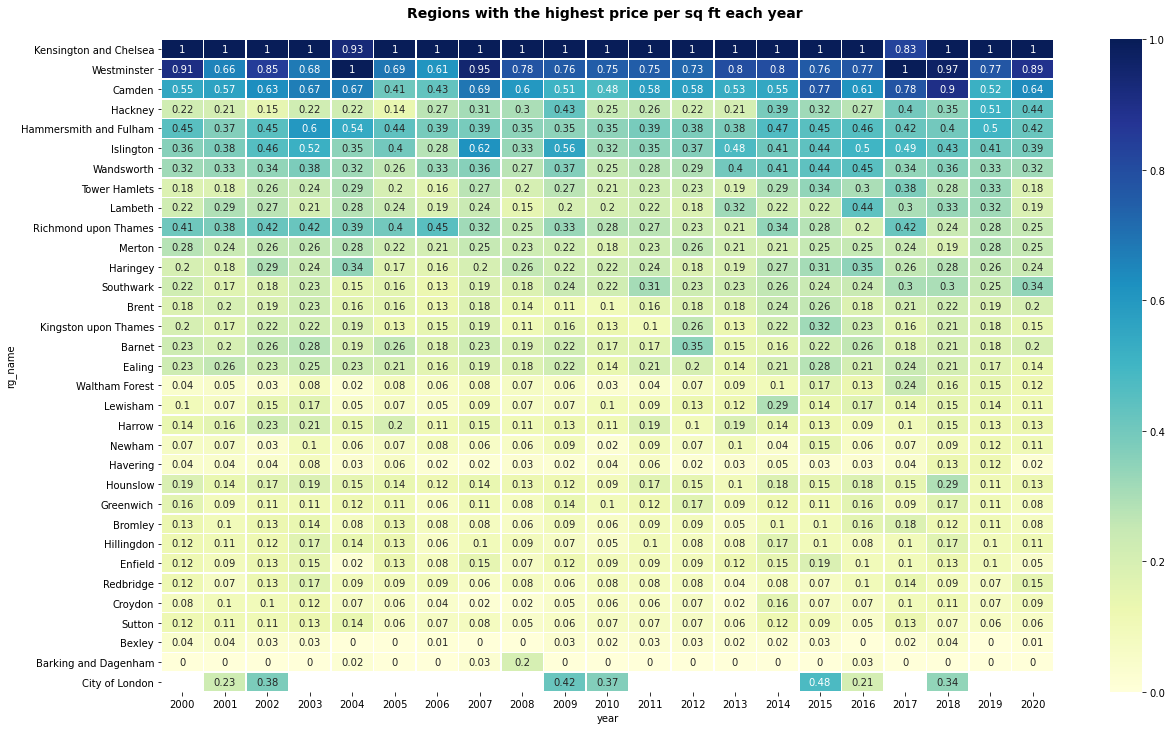

In [423]:
#### By Region view prices
####

# Reshape data into pivot table
result_pv = pd.pivot_table(result[result.year > 1999], index="rg_name", columns="year", values="sqft_price")
# Normalize data across each row, for each region ensure the avg price is represented as a number between 0 and 1
result_pv2 = result_pv.subtract(result_pv.min(axis=1), axis=0).div(result_pv.max(axis=1) -result_pv.min(axis=1), axis=0).round(2).sort_values(by=2019, ascending=False)
result_pv3 = result_pv.subtract(result_pv.min(axis=0), axis=1).div(result_pv.max(axis=0) -result_pv.min(axis=0), axis=1).round(2).sort_values(by=2019, ascending=False)

# Plot 
fig, ax = plt.subplots(figsize=(20, 12))
sns.heatmap(result_pv3, annot=True, linewidths=.5, ax=ax, cmap="YlGnBu")
ax.set_title("Regions with the highest price per sq ft each year \n", fontweight='bold', fontsize=14)
plt.show()

In [224]:
# # Get Data from AWS RDS PostgresSQL DB (all data within the database is publicly available and been scrapped and collected by myself)

# engine = psycopg2.connect(database="postgres", user=secrets.user(), password=secrets.password(), host=secrets.host(), port='5432')
# cur = engine.cursor()

# cur.execute("""

# SELECT 
#     CAST (p.year AS INTEGER), p.new, p.duration, p.type, g.rg_name, g.geometry,
#     CAST(ROUND(AVG(p.price)::numeric,0 ) as integer) as avg_price,
#     CAST(ROUND(AVG(e.total_floor_area)::numeric,0 ) as integer) as avg_sqft,
#     CAST(ROUND(AVG(e.number_habitable_rooms)::numeric,0 ) as integer) as avg_rooms,
#     CAST(ROUND( AVG(p.price/e.total_floor_area)::numeric, 3 ) as integer) as sqft_price,
#     CAST(ROUND( AVG(p.price/e.number_habitable_rooms)::numeric, 3 ) as integer) as price_per_room

# from prices as p
# join epc as e
# on e.brn = p.brn
# join geo as g
# on p.lsoa = g.lsoa
# where e.total_floor_area <> 0 and e.number_habitable_rooms <> 0 and e.number_habitable_rooms is not null and e.total_floor_area is not null

# group by p.year, p.new, p.duration, p.type, g.rg_name, g.geometry;

# """)
# rows = cur.fetchall()
# result = pd.DataFrame(rows, columns = [desc[0] for desc in cur.description])
# result.head(2)

/home/elena/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:373: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


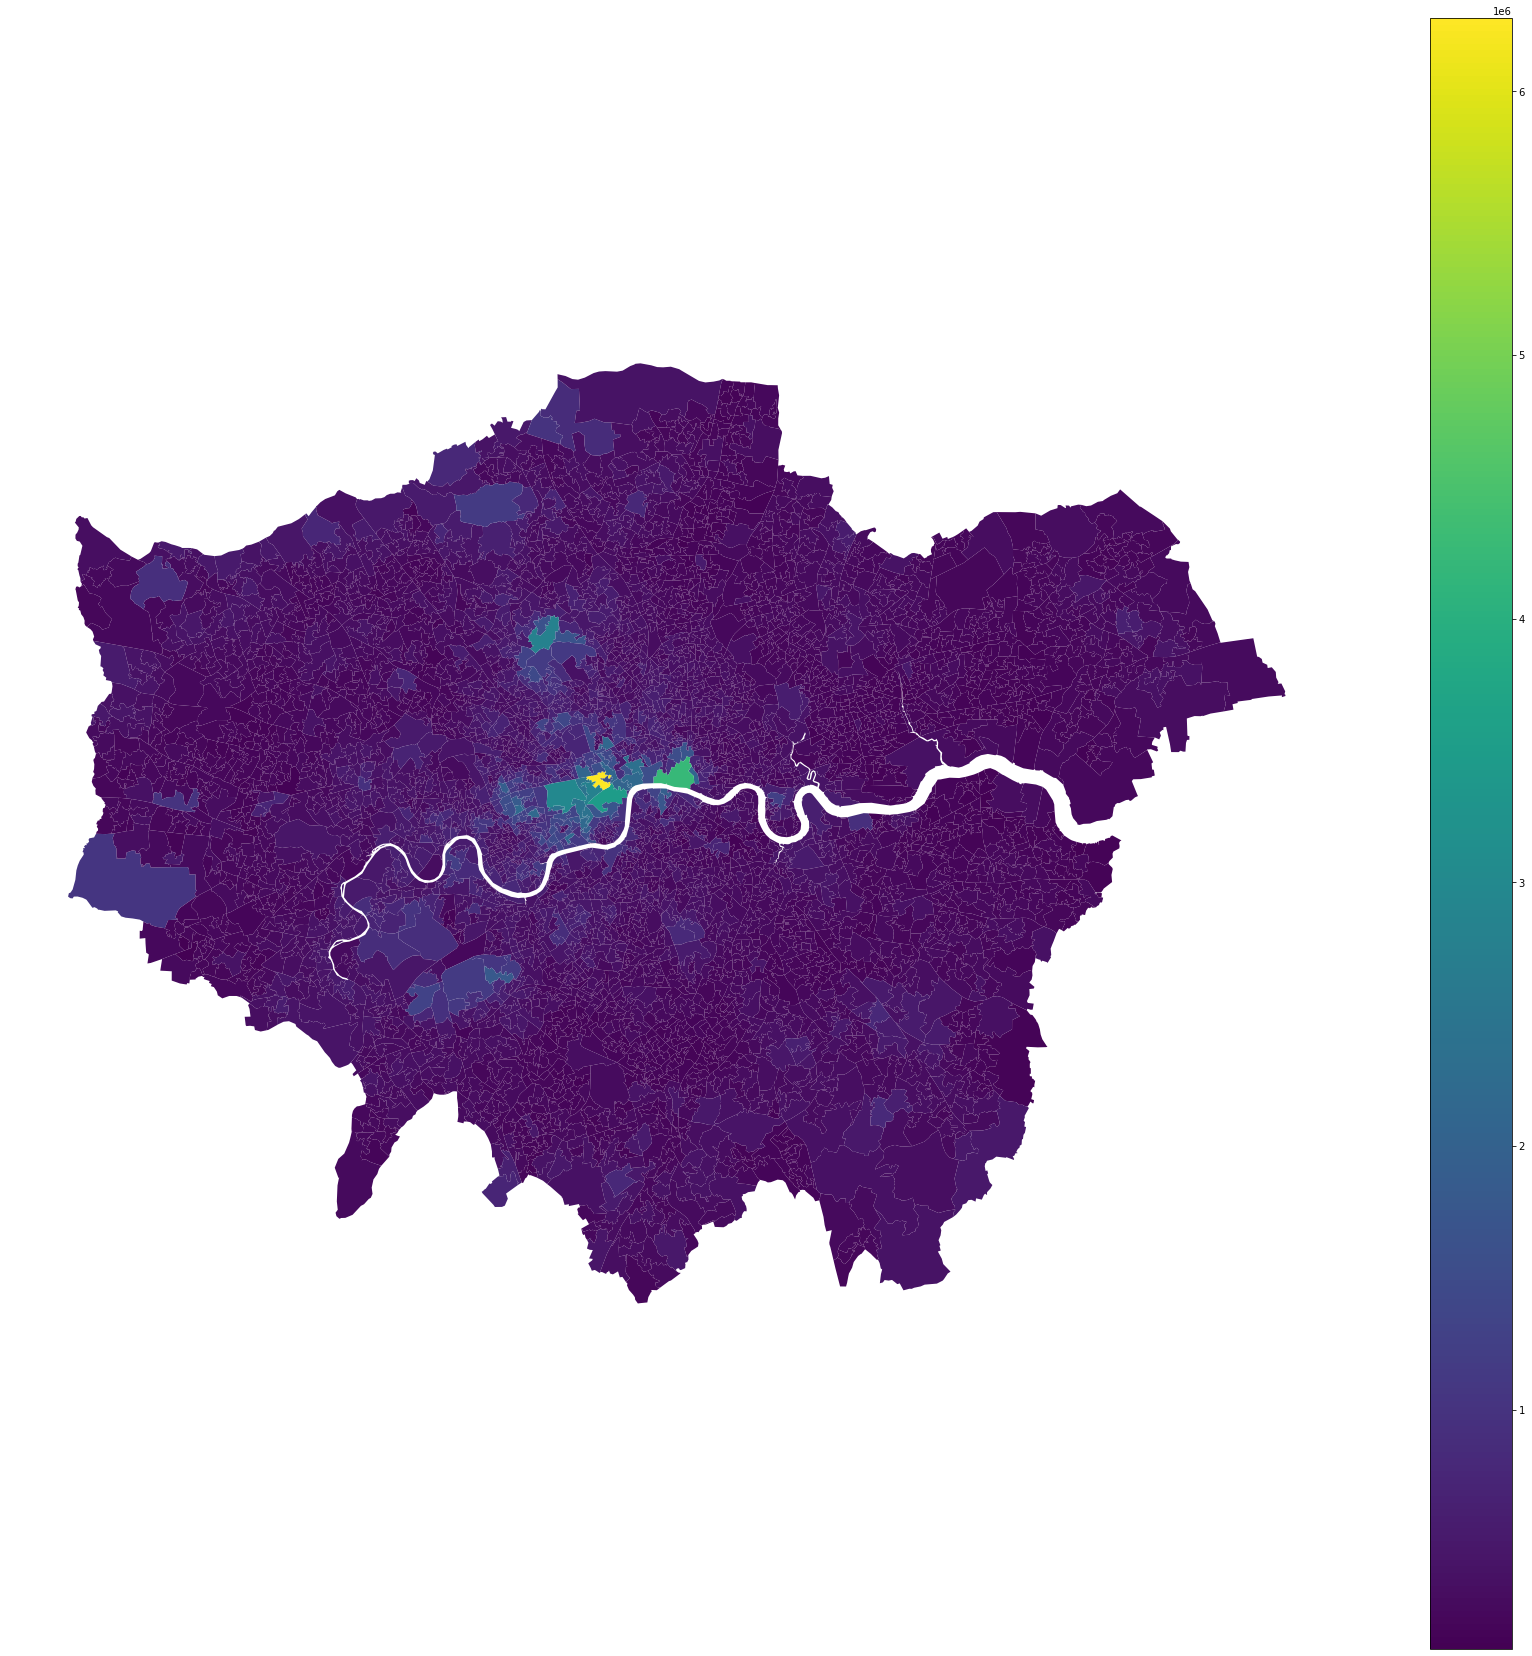